Imports and constants assignation

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

### Constants
samples_per_record = 3327
fs = 16000
inputs = []
outputs = []

# List of commands that the nn will recognize
commands = ['now', 'take','fetch','noise','cancel','driver','pillow','slider','rod','stop','wrench','piston','crank']
num_commands = len(commands)

# create a one-hot encoded matrix that is used in the output
encoded_commands = np.eye(num_commands)

# Definir los parámetros para el espectrograma
win = np.hamming(1024)
nfft = 1024
hop = nfft // 2


Data parse

In [17]:

# read each csv file and push an input and output
for command_idx in range(num_commands):
  command = commands[command_idx]
  print(f"Processing index {command_idx} for command '{command}'.")
  
  output = encoded_commands[command_idx]
  
  df = np.loadtxt("data_set/" + command + ".txt")
  
  # calculate the number of command recordings in the file
  num_recordings = int(df.shape[0] / samples_per_record)
  
  print(f"\tThere are {num_recordings} recordings of the {command} command.")
  
  for i in range(num_recordings):
    tensor = []
    # print(i*samples_per_record)
    # print()
    start = i*samples_per_record
    end = start+samples_per_record
    spec, freqs, times, _ = plt.specgram(df[start:end], NFFT=nfft, Fs=fs, window=win, noverlap=hop, mode='magnitude')
    plt.close()
    tensor = spec

    inputs.append(tensor)
    outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

print("Data set parsing and preparation complete.")



Processing index 0 for command 'now'.
	There are 115 recordings of the now command.
Processing index 1 for command 'take'.
	There are 108 recordings of the take command.
Processing index 2 for command 'fetch'.
	There are 110 recordings of the fetch command.
Processing index 3 for command 'noise'.
	There are 105 recordings of the noise command.
Processing index 4 for command 'cancel'.
	There are 109 recordings of the cancel command.
Processing index 5 for command 'driver'.
	There are 103 recordings of the driver command.
Processing index 6 for command 'pillow'.
	There are 101 recordings of the pillow command.
Processing index 7 for command 'slider'.
	There are 121 recordings of the slider command.
Processing index 8 for command 'rod'.
	There are 100 recordings of the rod command.
Processing index 9 for command 'stop'.
	There are 100 recordings of the stop command.
Processing index 10 for command 'wrench'.
	There are 110 recordings of the wrench command.
Processing index 11 for command '

Randomize samples

In [18]:
# Sort inputs randomly
num_inputs = len(inputs)
random_idx = np.arange(num_inputs)
np.random.shuffle(random_idx)

inputs = inputs[random_idx]
outputs = outputs[random_idx]

# Split the inputs into: training (60%), testing(20%) and validation(20%)
train_idx = int(0.6 * num_inputs)
test_idx = int(0.2 * num_inputs + train_idx)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [train_idx, test_idx])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [train_idx, test_idx])

# Ajustar la forma de los datos de entrada
inputs_train = np.expand_dims(inputs_train, axis=1)
inputs_validate = np.expand_dims(inputs_validate, axis=1)
inputs_test = np.expand_dims(inputs_test, axis=1)

print("Data set randomization and splitting complete.")

Data set randomization and splitting complete.


Model training and bulding

In [35]:
# build the model and train it

# Define the input shape
input_shape = inputs_train[1].shape

# Define the number of filters and filter sizes for the first layer
filters_layer_1 = 32
filter_size_layer_1 = (3,3)
model = 0
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters=filters_layer_1, padding='same', kernel_size=filter_size_layer_1,activation='relu', input_shape=input_shape))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(num_commands, activation='softmax'))
# model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
# optimizer= adam loss= crossentropy metrics = accuracy
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(inputs_train, outputs_train, epochs=100, batch_size=10, validation_data=(inputs_validate, outputs_validate))

Epoch 1/100
84/84 [==============================] - 1s 11ms/step - loss: 2.0853 - accuracy: 0.2969 - val_loss: 1.8020 - val_accuracy: 0.3525
Epoch 2/100
84/84 [==============================] - 1s 10ms/step - loss: 1.2520 - accuracy: 0.5385 - val_loss: 1.3223 - val_accuracy: 0.5180
Epoch 3/100
84/84 [==============================] - 1s 9ms/step - loss: 0.7330 - accuracy: 0.7440 - val_loss: 0.9243 - val_accuracy: 0.6906
Epoch 4/100
84/84 [==============================] - 1s 10ms/step - loss: 0.4521 - accuracy: 0.8498 - val_loss: 0.7782 - val_accuracy: 0.7122
Epoch 5/100
84/84 [==============================] - 1s 10ms/step - loss: 0.3104 - accuracy: 0.9050 - val_loss: 0.7881 - val_accuracy: 0.7374
Epoch 6/100
84/84 [==============================] - 1s 10ms/step - loss: 0.2260 - accuracy: 0.9387 - val_loss: 0.9365 - val_accuracy: 0.7086
Epoch 7/100
84/84 [==============================] - 1s 10ms/step - loss: 0.1454 - accuracy: 0.9651 - val_loss: 0.8764 - val_accuracy: 0.7158
Epoch 8

Loss graph

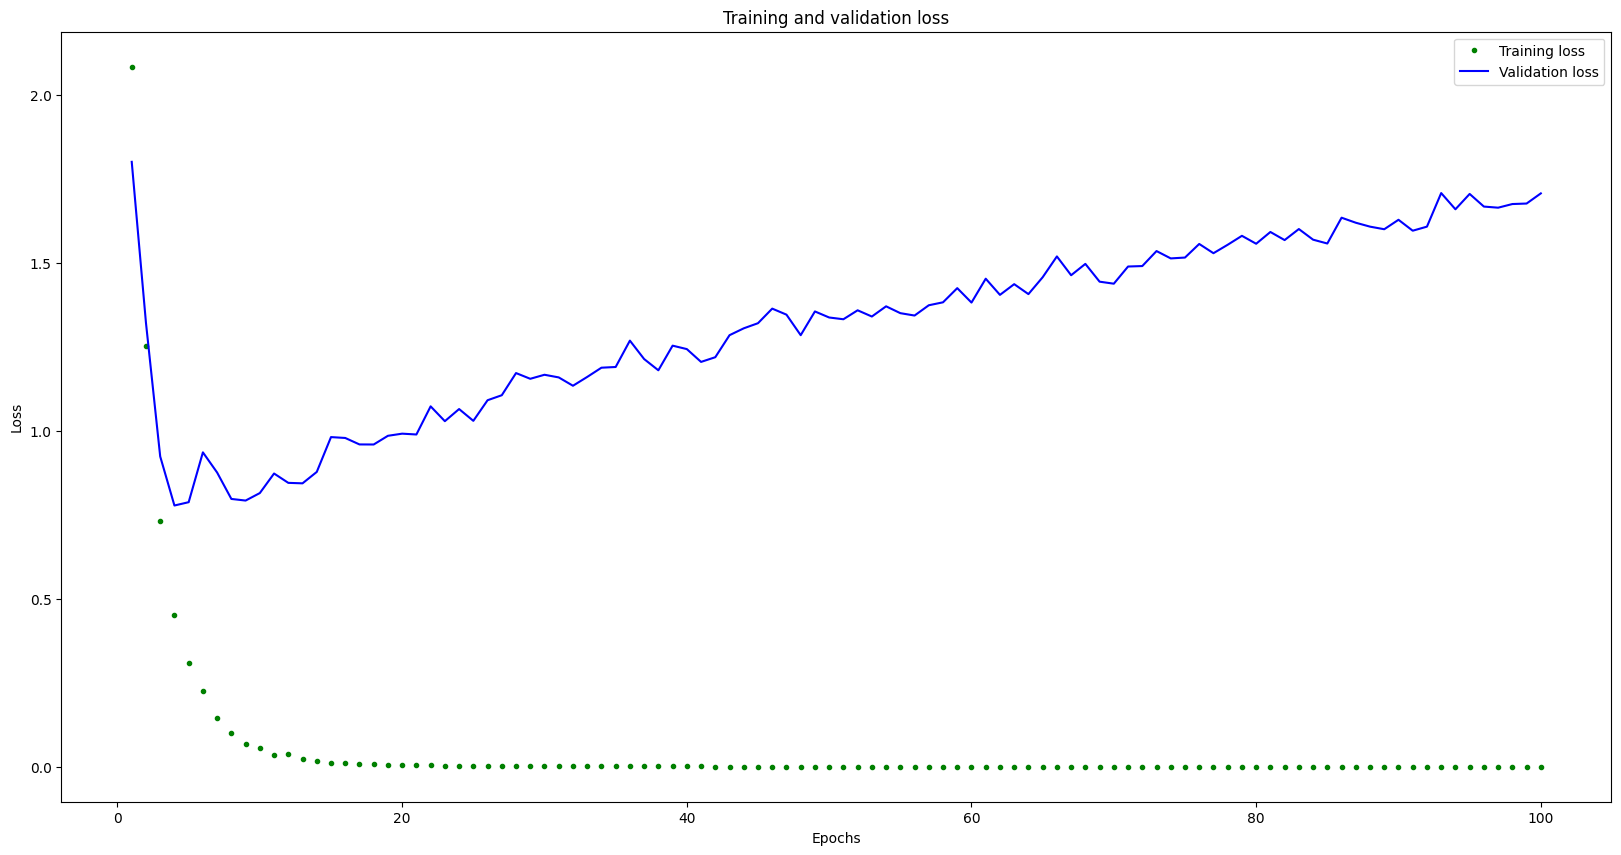

In [37]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


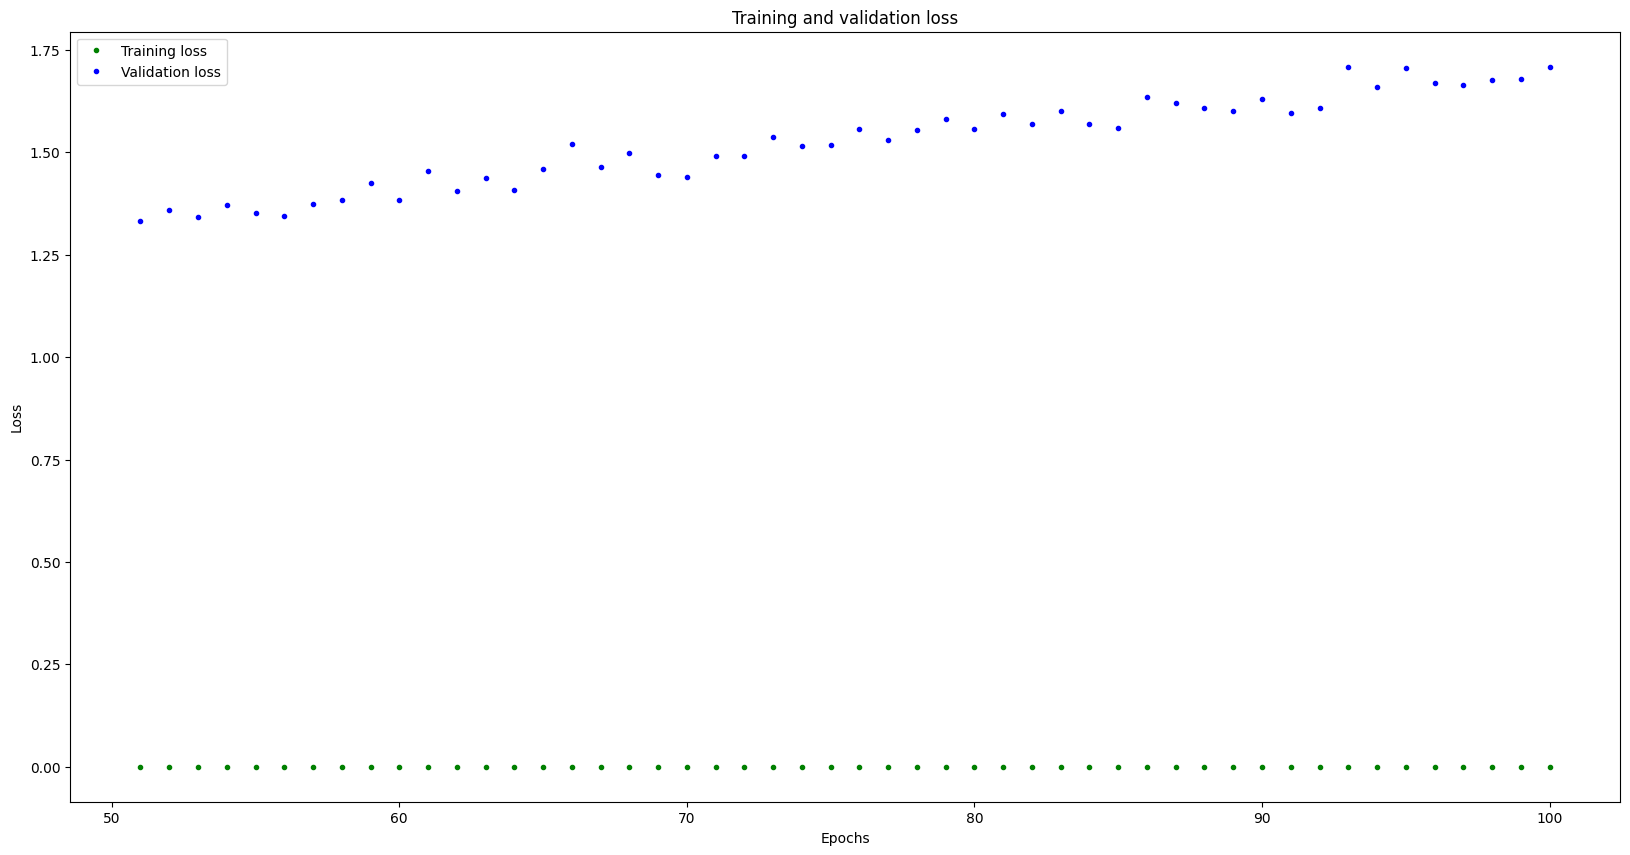

In [38]:
# graph the loss again skipping a bit of the start
SKIP = 50
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Accuracy graph

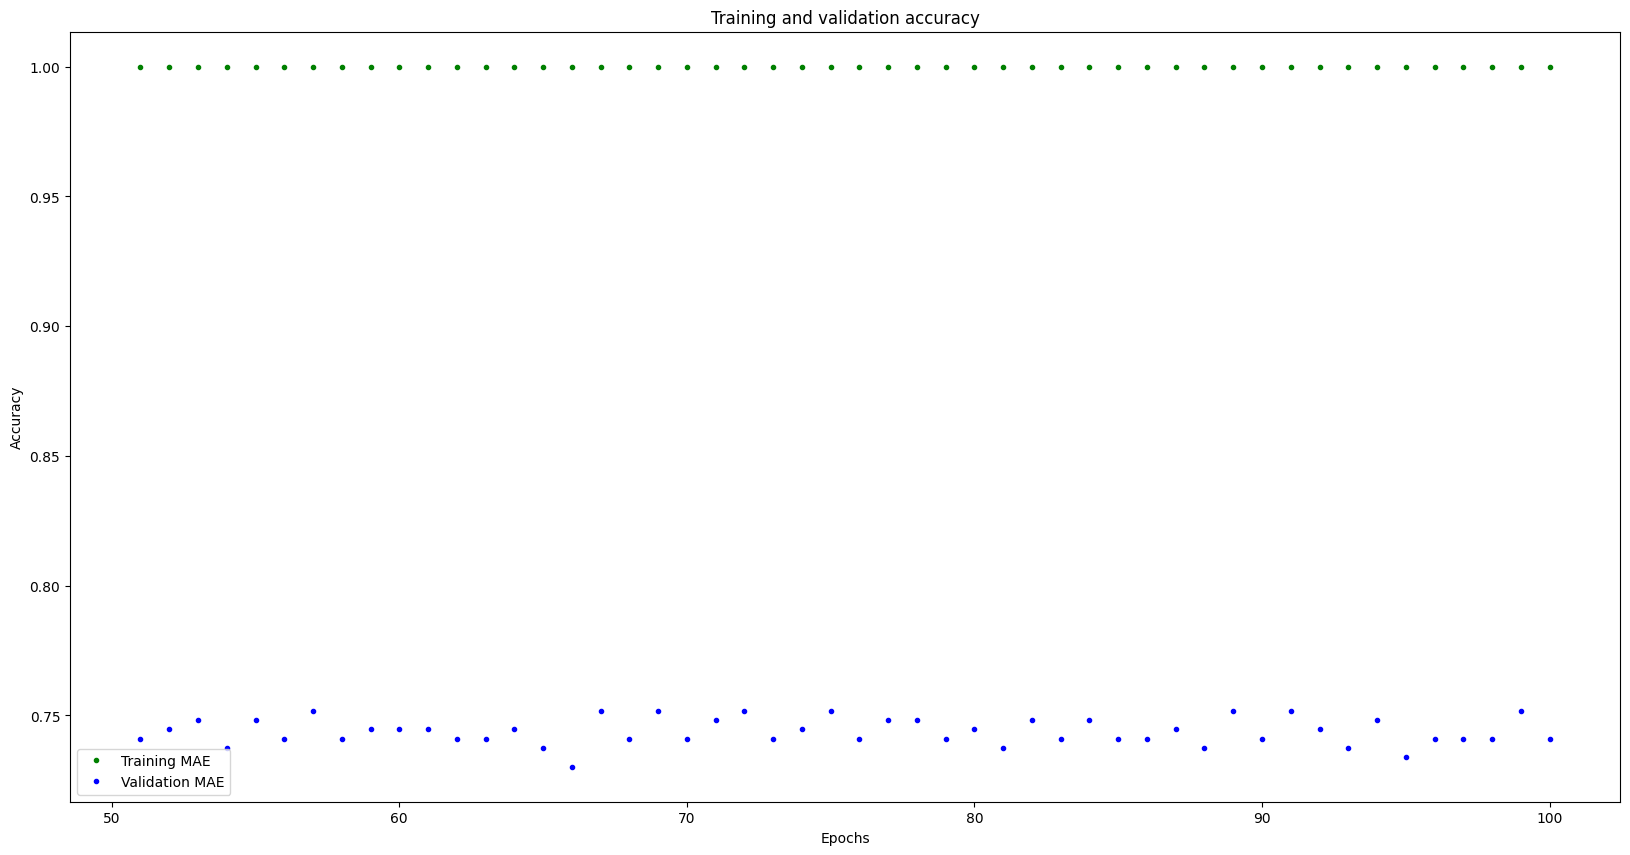

In [39]:
# graph of mean absolute error
mae = history.history['accuracy']
val_mae = history.history['val_accuracy']
plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training accuracy')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Test model predictions

9/9 [==============================] - 0s 6ms/step
class: 13
[[18.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 13.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.]
 [ 0.  2. 22.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 17.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1. 22.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. 21.  1.  1.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  1. 17.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1. 19.  0.  0.  0.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 16. 13.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  2. 13.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 19.  0.  2.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1. 21.  3.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  0. 19.]]


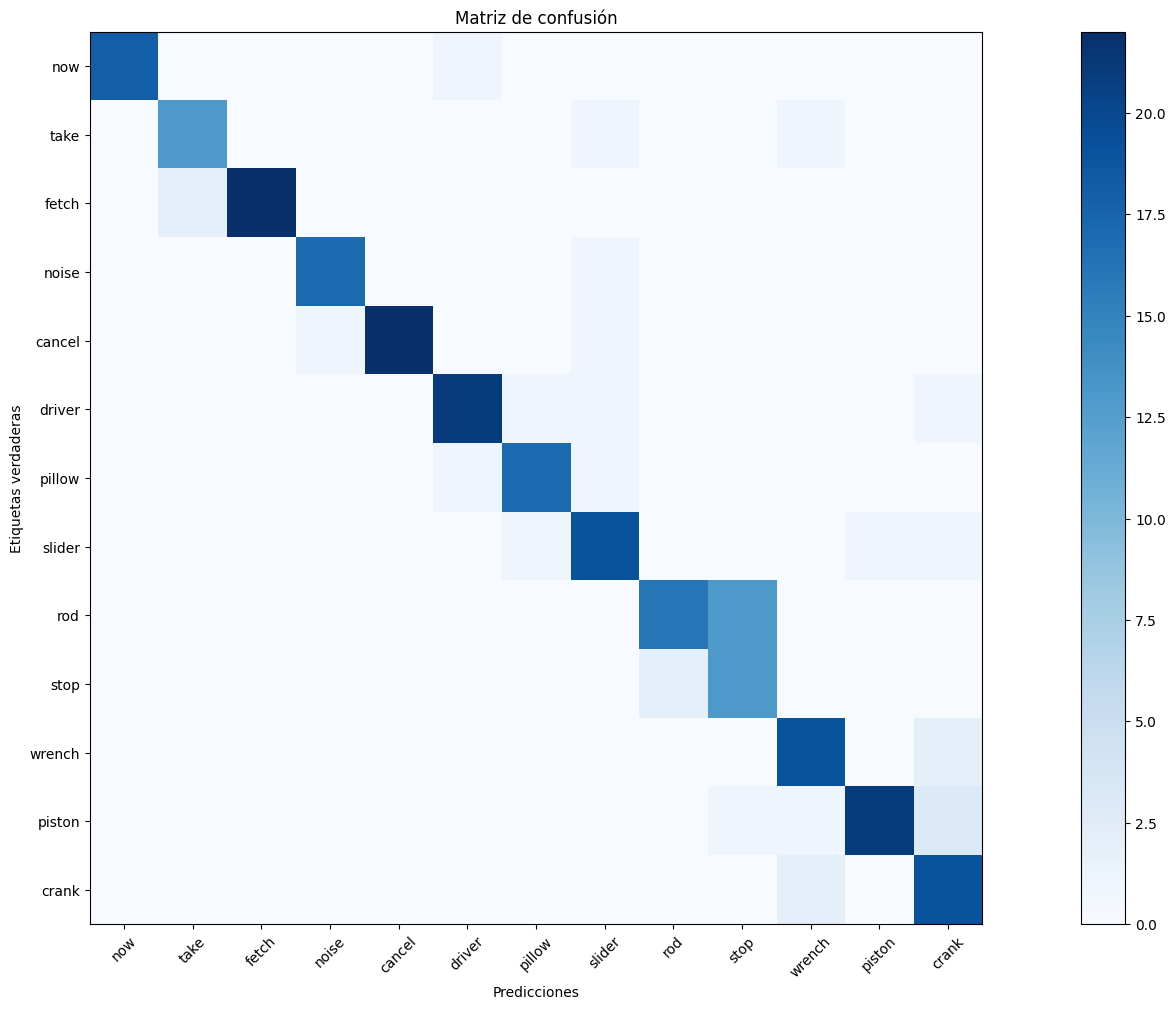

In [34]:
# use the model to predict the test inputs
# inputs_test = np.expand_dims(inputs_test, axis=1)
predictions = model.predict(inputs_test)

import numpy as np
import matplotlib.pyplot as plt

# Calcula la matriz de confusión utilizando NumPy
num_classes = len((outputs_test[1]))
print('class:',num_classes)
confusion_matrix = np.zeros((num_classes, num_classes))

for i in range(len(outputs_test)):
    true_class = np.argmax(outputs_test[i])
    predicted_class = np.argmax(predictions[i])
    # print(predicted_class)
    # print(true_class)
    confusion_matrix[true_class][predicted_class] += 1

print(confusion_matrix)

# Imprime la matriz de confusión utilizando la biblioteca matplotlib.pyplot
plt.imshow(confusion_matrix, cmap=plt.cm.Blues)
plt.title("Matriz de confusión")
plt.colorbar()
tick_marks = np.arange(len(commands))
plt.xticks(tick_marks, commands, rotation=45)
plt.yticks(tick_marks, commands)
plt.tight_layout()
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas verdaderas')
plt.show()



# for i in range(len(predictions)):
#     # print the predictions and the expected ouputs
#     print("predictions =\n", np.round(predictions[i]))
#     print("actual =\n", outputs_test[i])


Convert model to tensorflow lite

In [25]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("command_model.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("command_model.tflite")
print("Model is %d bytes" % basic_model_size)

INFO:tensorflow:Assets written to: C:\Users\enric\AppData\Local\Temp\tmpbdhqbcn8\assets


INFO:tensorflow:Assets written to: C:\Users\enric\AppData\Local\Temp\tmpbdhqbcn8\assets


Model is 2111536 bytes
